In [5]:
# import all the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
import h5py

! pip install xlrd

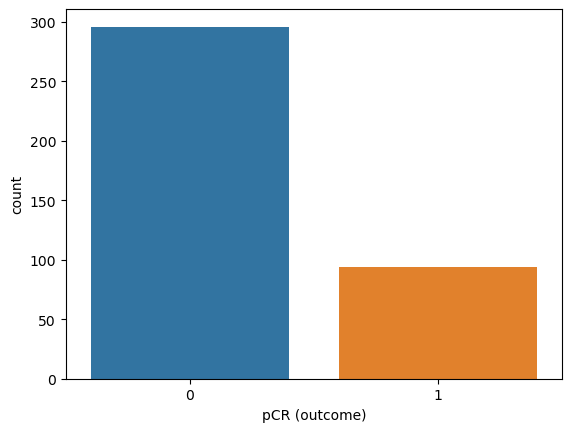

In [6]:
all_df = pd.read_excel('trainDataset.xls', index_col=False)

all_df = all_df.drop('ID', axis=1)

invalid = []

for index, row in all_df.iterrows():
    for key in row.keys():
        if row[key] == 999:
            invalid.append(index)

all_df = all_df.drop(index = invalid)
all_df = all_df.drop('RelapseFreeSurvival (outcome)', axis=1)

sns.countplot(x="pCR (outcome)", data=all_df)

['Age', 'original_shape_Elongation', 'original_shape_SurfaceArea', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_Range', 'original_firstorder_TotalEnergy', 'original_glcm_Autocorrelation', 'original_glcm_ClusterShade', 'original_glcm_Correlation', 'original_glcm_Imc1', 'original_glcm_JointAverage', 'original_glcm_MCC', 'original_glcm_SumAverage', 'original_gldm_HighGrayLevelEmphasis', 'original_gldm_LargeDependenceLowGrayLevelEmphasis', 'original_gldm_LowGrayLevelEmphasis', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_RunLengthNonUniformity', 'original_glszm_GrayLevelNonUniformity', 'original_glszm_HighGrayLevelZoneEmphasis', 'original_glszm_LargeAreaEmphasis', 'original_glszm_LargeAreaHighGrayLevelEmphasis', 'original_glszm_LargeAreaLowGrayLevelEmphasis', 'original_glszm_LowGrayLevelZoneEmphasis', 'original_glszm_SizeZoneNonUniformity', 'original_glszm_SizeZoneNonUniform

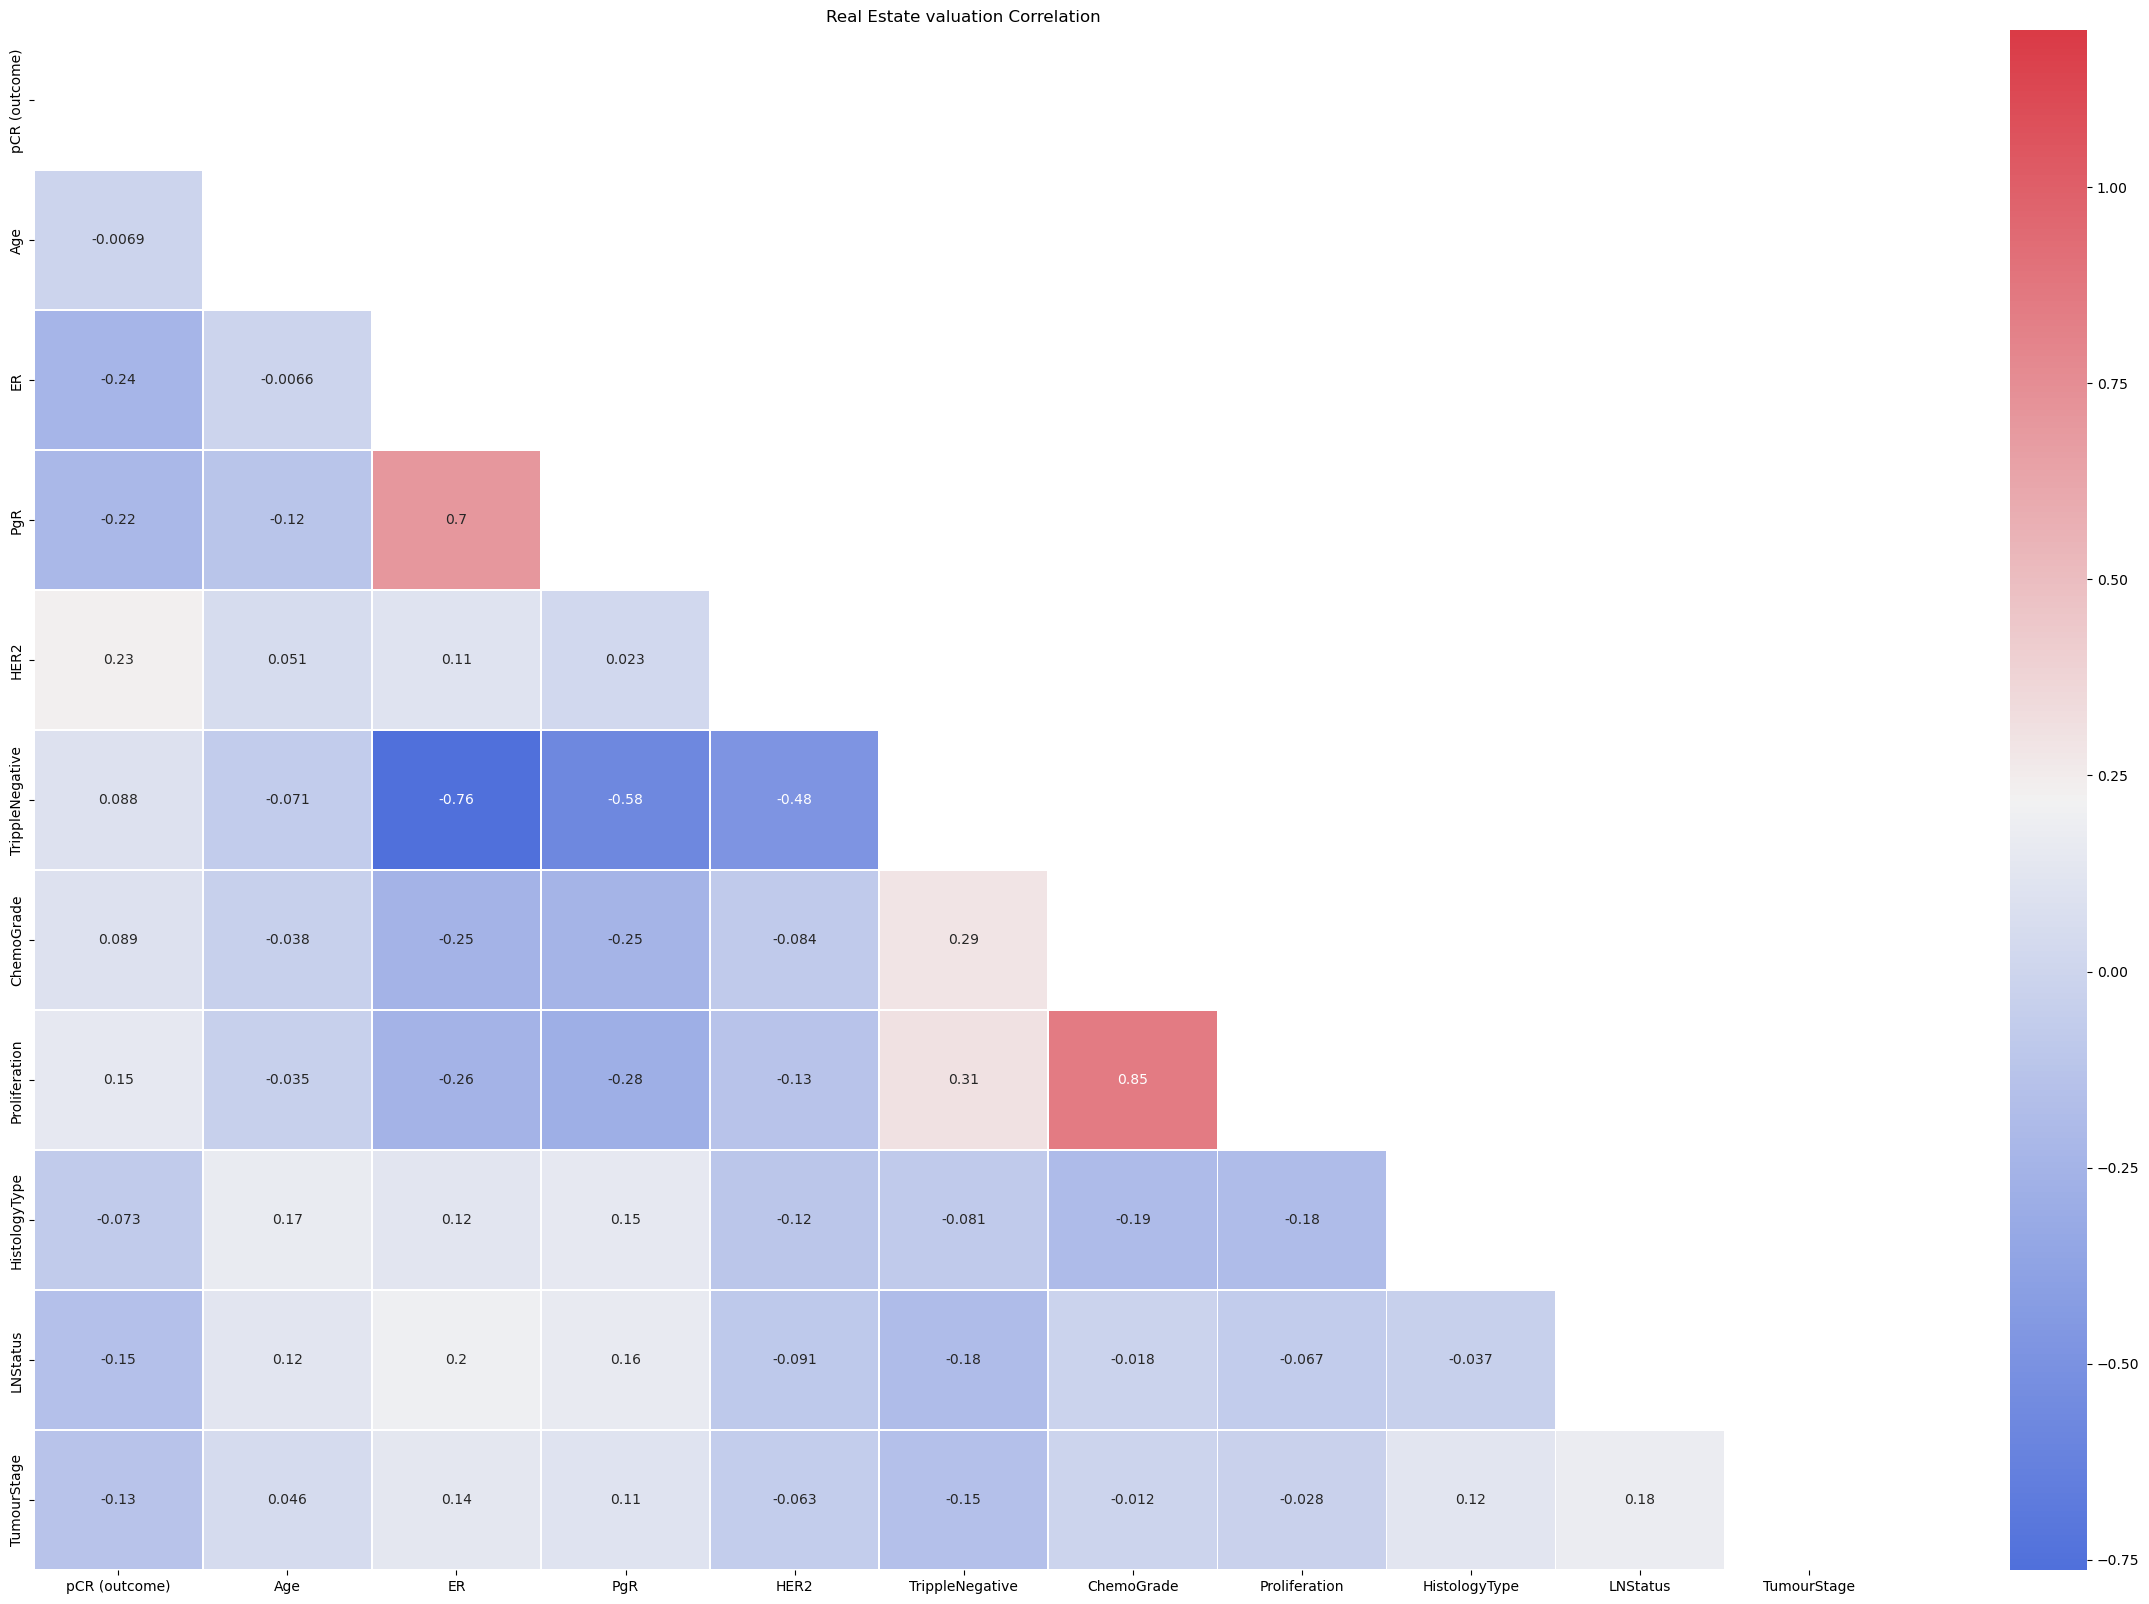

In [7]:
corrMatt = all_df.iloc[:,0:11].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(30, 20))
plt.title('Real Estate valuation Correlation')
# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask, ax=ax, annot=True, fmt='.2g', linewidths=0.5);

wholeCorrMatt = all_df.corr()

weak = []

for index, row in wholeCorrMatt.iterrows():
    if abs(row['pCR (outcome)']) < 0.05:
        weak.append(index)

all_df = all_df.drop(columns=weak,axis=1)

print(weak)

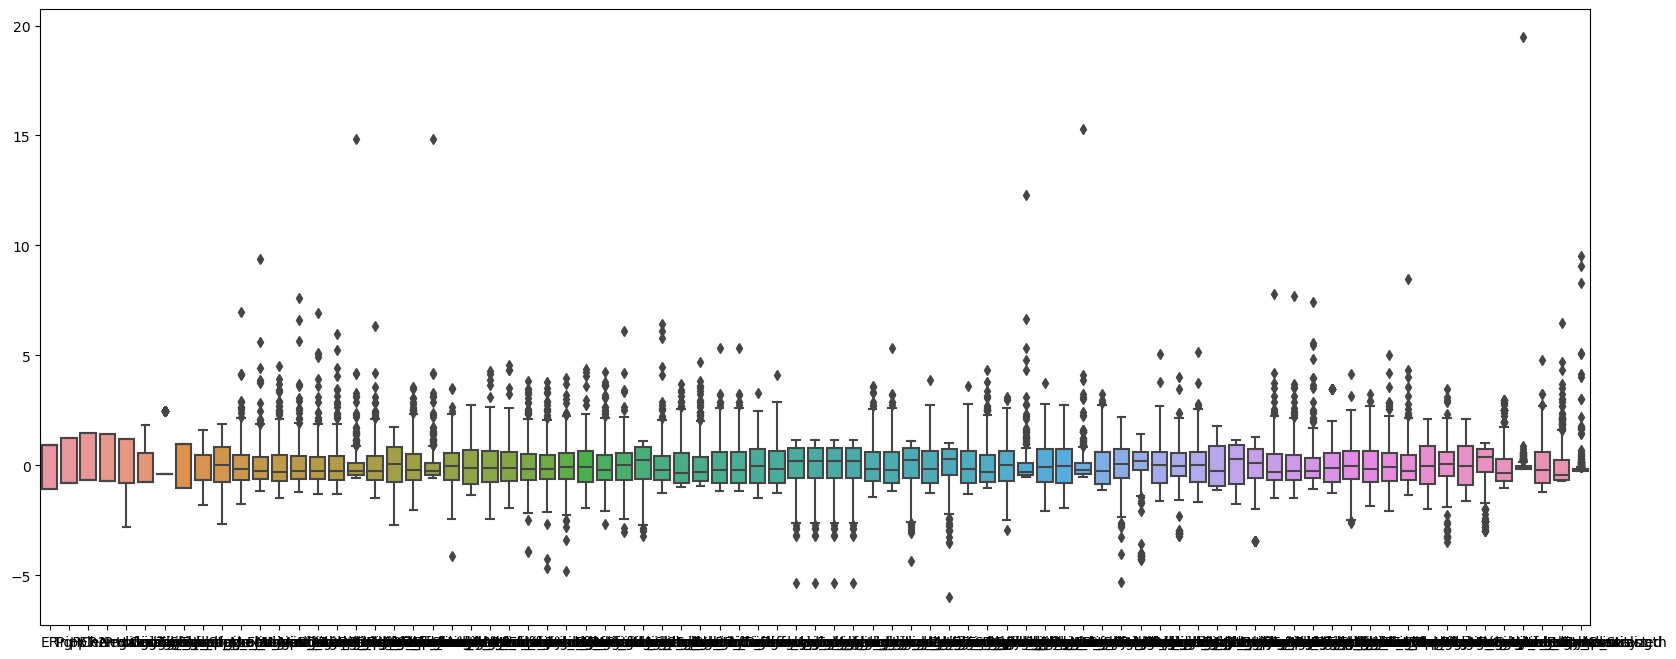

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
all_df.iloc[:,1:] = scaler.fit_transform(all_df.iloc[:,1:])
fig,ax=plt.subplots(1,figsize=(20,8))
sns.boxplot(data=all_df.iloc[:,1:],ax=ax)

In [9]:
from collections import Counter

def detect_outliers(df, n, features):
    '''
    这种方法允许输入是nan值
    df: 表示dataFrame类型
    n: 表示被多少个特征判定为异常点才输出
    features: 表示检测异常点的特征
    '''
    # 用来保存异常点的索引
    outlier_indices = []
    for col in features:
        ## 第1个四分位点
        Q1 = np.percentile(df[col], 25)
        ## 第3个四分位点
        Q3 = np.percentile(df[col], 75)
        
        IQR = Q3 - Q1 
        
        lower_limit = Q1 - 1.5 * IQR  # 下界
        upper_limit = Q3 + 1.5 * IQR  # 上届
        
        outlier_list_col = df[(df[col]<lower_limit) | (df[col] > upper_limit)].index
        
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    # 如果被n个特征判定为异常点，则输出
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

rows = detect_outliers(all_df,1,all_df.iloc[:,1:])

all_df = all_df.drop(index=rows, axis=0)

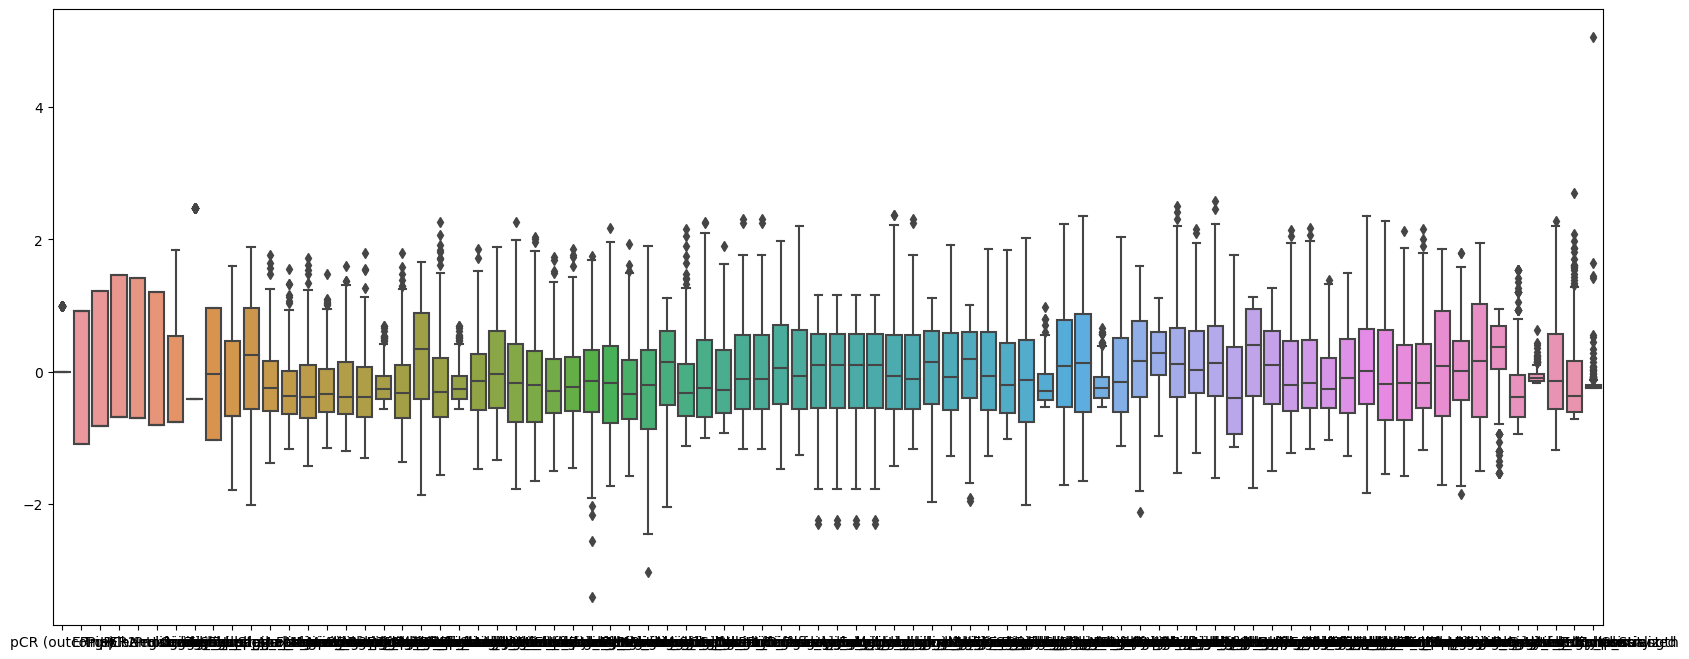

In [10]:
fig,ax=plt.subplots(1,figsize=(20,8))
sns.boxplot(data=all_df,ax=ax)

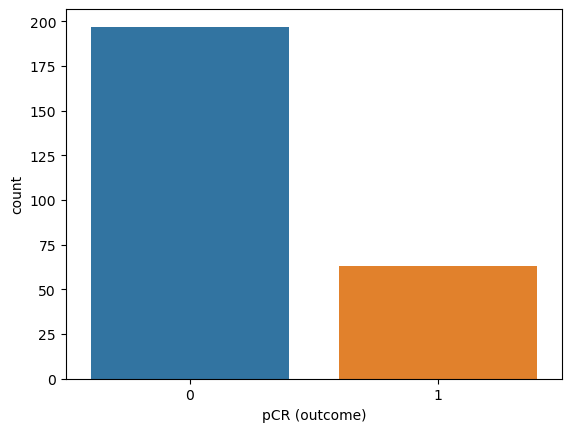

In [11]:
sns.countplot(x="pCR (outcome)", data=all_df)

### SVM

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

features = all_df.iloc[:,1:]
pCR = all_df["pCR (outcome)"]
svm = SVC(kernel="rbf", gamma='auto', degree=3)

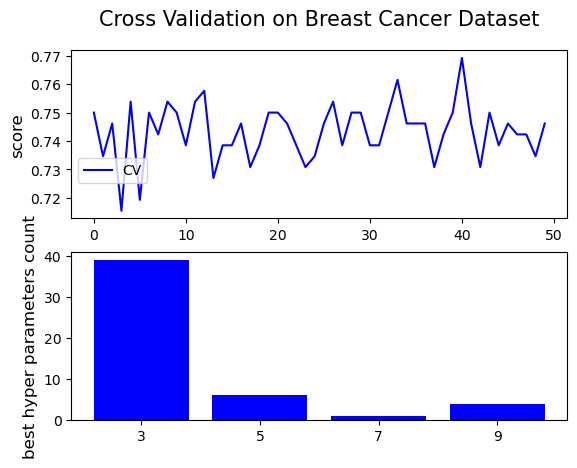

In [12]:
NUM_TRIALS = 50
X = features
y = pCR

# Set up possible values of parameters to optimize over
p_grid = {"C": [3, 5, 7, 9]}

scores = np.zeros(NUM_TRIALS)
params = []

for i in range(NUM_TRIALS):

    cv = KFold(n_splits=5, shuffle=True, random_state=i)

    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=cv)
    clf.fit(X,y)
    scores[i] = clf.best_score_
    params.append(clf.best_params_)


best_hyper_params_count = np.zeros(4)
for i in params:
    if params.count(i) >= 1:
        best_hyper_params_count[int((i["C"]-3)/2)] = params.count(i)

# Plot scores on each trial for CV
plt.figure()
plt.subplot(211)
(line,) = plt.plot(scores, color="b")
plt.ylabel("score", fontsize="12")
plt.legend(
    [line],
    ["CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Cross Validation on Breast Cancer Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

plt.subplot(212)

plt.bar(range(len(best_hyper_params_count)), best_hyper_params_count,fc='b', tick_label=[3, 5, 7, 9])
plt.ylabel("best hyper parameters count", fontsize="12")
plt.show()

0.7307692307692307


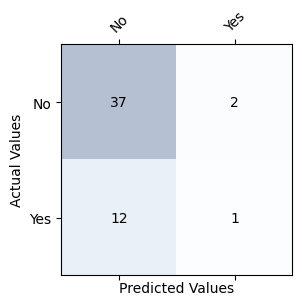

In [13]:
svm = SVC(C = 3.0, kernel="rbf", gamma='auto', degree=3)
X_train, X_test, y_train, y_test = train_test_split(features, pCR, test_size=0.2, random_state=3, stratify=pCR)
pred = svm.fit(X_train,y_train).predict(X_test)
cm = confusion_matrix(y_test, pred)
pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(accuracy)
# Plot confusion matrix,
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
classes=["No","Yes"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values')
plt.show()

### Random Forest

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

features = all_df.iloc[:,1:]
pCR = all_df["pCR (outcome)"]

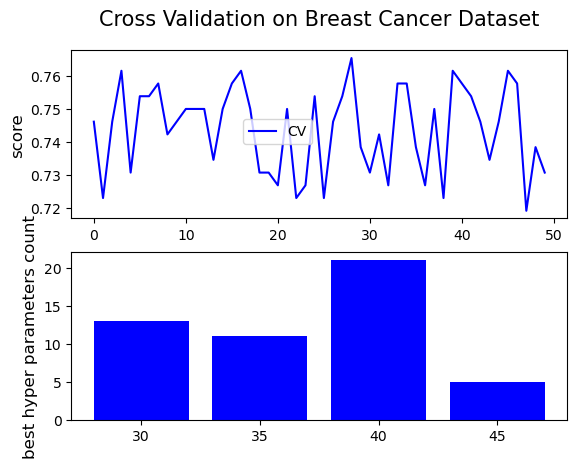

In [15]:
NUM_TRIALS = 50
X = features
y = pCR

rf_model = RandomForestClassifier(random_state=66)
n_estimators_grid = {"n_estimators": [30, 35, 40, 45]}
scores = np.zeros(NUM_TRIALS)
params = []

for i in range(NUM_TRIALS):

    cv = KFold(n_splits=5, shuffle=True, random_state=i)

    clf = GridSearchCV(estimator=rf_model, param_grid=n_estimators_grid, cv=cv)
    clf.fit(X,y)
    scores[i] = clf.best_score_
    params.append(clf.best_params_)

best_hyper_params_count = np.zeros(4)
for i in params:
    if params.count(i) >= 1:
        best_hyper_params_count[int(i["n_estimators"]/5 - 6)] = params.count(i)

# Plot scores on each trial for CV
plt.figure()
plt.subplot(211)
(line,) = plt.plot(scores, color="b")
plt.ylabel("score", fontsize="12")
plt.legend(
    [line],
    ["CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Cross Validation on Breast Cancer Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

plt.subplot(212)

plt.bar(range(len(best_hyper_params_count)), best_hyper_params_count,fc='b', tick_label=[30, 35, 40, 45])
plt.ylabel("best hyper parameters count", fontsize="12")
plt.show()


0.7115384615384616


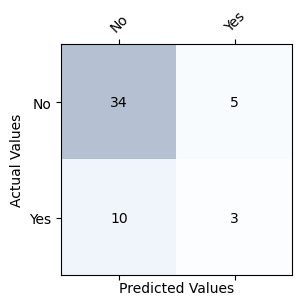

In [16]:
rf_model = RandomForestClassifier(n_estimators=40, random_state=66)
X_train, X_test, y_train, y_test = train_test_split(features, pCR, test_size=0.2, random_state=44, stratify=pCR)
rf_model.fit(X_train, y_train)
pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(accuracy)
cm = confusion_matrix(y_test, pred)

# Plot confusion matrix,
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
classes=["No","Yes"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values')
plt.show()

### ANN

In [12]:
from tensorflow import keras
from tensorflow.keras.optimizers import SGD

x_train, x_test, y_train, y_test = train_test_split(all_df.iloc[:,1:], all_df['pCR (outcome)'], test_size=0.3, random_state=1, stratify=all_df['pCR (outcome)'])

print(x_train.shape[1])
# initiate all the models separately with one and two layers, and with learning rate of 0.1, 0.01, 0.001
model_one_layer_1=keras.models.Sequential()
model_one_layer_1.add(keras.layers.Dense(32, input_shape=(x_train.shape[1],), activation="relu"))
model_one_layer_1.add(keras.layers.Dense(1, activation='sigmoid'))

model_one_layer_2=keras.models.Sequential()
model_one_layer_2.add(keras.layers.Dense(32, input_shape=(x_train.shape[1],), activation="relu"))
model_one_layer_2.add(keras.layers.Dense(1, activation='sigmoid'))

model_one_layer_3=keras.models.Sequential()
model_one_layer_3.add(keras.layers.Dense(32, input_shape=(x_train.shape[1],), activation="relu"))
model_one_layer_3.add(keras.layers.Dense(1, activation='sigmoid'))

model_one_layer_1.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.1), metrics=['accuracy'])
model_one_layer_2.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])
model_one_layer_3.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001), metrics=['accuracy'])

model_two_layer_1=keras.models.Sequential()
model_two_layer_1.add(keras.layers.Dense(32, input_shape=(x_train.shape[1],), activation="relu"))
model_two_layer_1.add(keras.layers.Dense(16 ,activation="relu"))
model_two_layer_1.add(keras.layers.Dense(1, activation='sigmoid'))

model_two_layer_2=keras.models.Sequential()
model_two_layer_2.add(keras.layers.Dense(32, input_shape=(x_train.shape[1],), activation="relu"))
model_two_layer_2.add(keras.layers.Dense(16 ,activation="relu"))
model_two_layer_2.add(keras.layers.Dense(1, activation='sigmoid'))

model_two_layer_3=keras.models.Sequential()
model_two_layer_3.add(keras.layers.Dense(32, input_shape=(x_train.shape[1],), activation="relu"))
model_two_layer_3.add(keras.layers.Dense(16 ,activation="relu"))
model_two_layer_3.add(keras.layers.Dense(1, activation='sigmoid'))

model_two_layer_1.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.1), metrics=['accuracy'])
model_two_layer_2.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])
model_two_layer_3.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001), metrics=['accuracy'])

81
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
from sklearn.model_selection import KFold
import os

def train_ann(features, target, model, name):
    root_logdir = os.path.join(os.curdir, "my_logs")
    def get_run_logdir():
         import time
         run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
         return os.path.join(root_logdir, run_id)

    run_logdir = get_run_logdir()
    kf = KFold(n_splits=5)
    k=1
    
    all_score = []

    for train_index, test_index in kf.split(features):
        print("fold",k)
        # Split the data
        X_train, X_test = np.array(features)[train_index], np.array(features)[test_index]
        y_train, y_test = np.array(target)[train_index], np.array(target)[test_index]
        
        tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
        early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=1)
        # training and validation
        model.fit(np.array(X_train), np.array(y_train), epochs=30, validation_data=(np.array(X_test), np.array(y_test)),callbacks=[tensorboard_cb, early_stopping])

        #save the model of each fold
        model.save(os.path.join('./classification_models/fold_{}_{}.hdf5'.format(k, name)))

        # evaluate the accuracy of each fold
        scores = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        
        k = k+1
    
        all_score.append(scores[1]*100)
    
    return all_score
        
six_ann_scores = []   

six_ann_scores.append(train_ann(features=all_df.iloc[:,1:], target=all_df['pCR (outcome)'], model=model_one_layer_1, name="model_one_layer_1"))
six_ann_scores.append(train_ann(features=all_df.iloc[:,1:], target=all_df['pCR (outcome)'], model=model_one_layer_2, name="model_one_layer_2"))
six_ann_scores.append(train_ann(features=all_df.iloc[:,1:], target=all_df['pCR (outcome)'], model=model_one_layer_3, name="model_one_layer_3"))
six_ann_scores.append(train_ann(features=all_df.iloc[:,1:], target=all_df['pCR (outcome)'], model=model_two_layer_1, name="model_two_layer_1"))
six_ann_scores.append(train_ann(features=all_df.iloc[:,1:], target=all_df['pCR (outcome)'], model=model_two_layer_2, name="model_two_layer_2"))
six_ann_scores.append(train_ann(features=all_df.iloc[:,1:], target=all_df['pCR (outcome)'], model=model_two_layer_3, name="model_two_layer_3"))

print(six_ann_scores)

fold 1
Train on 208 samples, validate on 52 samples
Epoch 1/30
208/208 [==============================] - 0s 535us/sample - loss: 0.6857 - acc: 0.5865 - val_loss: 0.4984 - val_acc: 0.8077
Epoch 2/30
208/208 [==============================] - 0s 42us/sample - loss: 0.6012 - acc: 0.7212 - val_loss: 0.4688 - val_acc: 0.8462
Epoch 3/30
208/208 [==============================] - 0s 61us/sample - loss: 0.5608 - acc: 0.7212 - val_loss: 0.4395 - val_acc: 0.8462
acc: 84.62%
fold 2
Train on 208 samples, validate on 52 samples
Epoch 1/30
208/208 [==============================] - 0s 52us/sample - loss: 0.5140 - acc: 0.7692 - val_loss: 0.4997 - val_acc: 0.7500
Epoch 2/30
208/208 [==============================] - 0s 52us/sample - loss: 0.4943 - acc: 0.7788 - val_loss: 0.4894 - val_acc: 0.7692
Epoch 3/30
208/208 [==============================] - 0s 61us/sample - loss: 0.4786 - acc: 0.7692 - val_loss: 0.4872 - val_acc: 0.8077
Epoch 4/30
208/208 [==============================] - 0s 52us/sample - lo

208/208 [==============================] - 0s 47us/sample - loss: 0.3561 - acc: 0.8413 - val_loss: 0.5513 - val_acc: 0.7115
acc: 71.15%
fold 1
Train on 208 samples, validate on 52 samples
Epoch 1/30
208/208 [==============================] - 0s 516us/sample - loss: 0.6065 - acc: 0.6875 - val_loss: 0.5126 - val_acc: 0.7500
Epoch 2/30
208/208 [==============================] - 0s 38us/sample - loss: 0.5967 - acc: 0.7019 - val_loss: 0.4988 - val_acc: 0.7885
Epoch 3/30
208/208 [==============================] - 0s 38us/sample - loss: 0.5876 - acc: 0.7163 - val_loss: 0.4852 - val_acc: 0.7885
acc: 78.85%
fold 2
Train on 208 samples, validate on 52 samples
Epoch 1/30
208/208 [==============================] - 0s 56us/sample - loss: 0.5678 - acc: 0.7404 - val_loss: 0.5208 - val_acc: 0.8077
Epoch 2/30
208/208 [==============================] - 0s 42us/sample - loss: 0.5580 - acc: 0.7404 - val_loss: 0.5144 - val_acc: 0.8269
Epoch 3/30
208/208 [==============================] - 0s 47us/sample - l

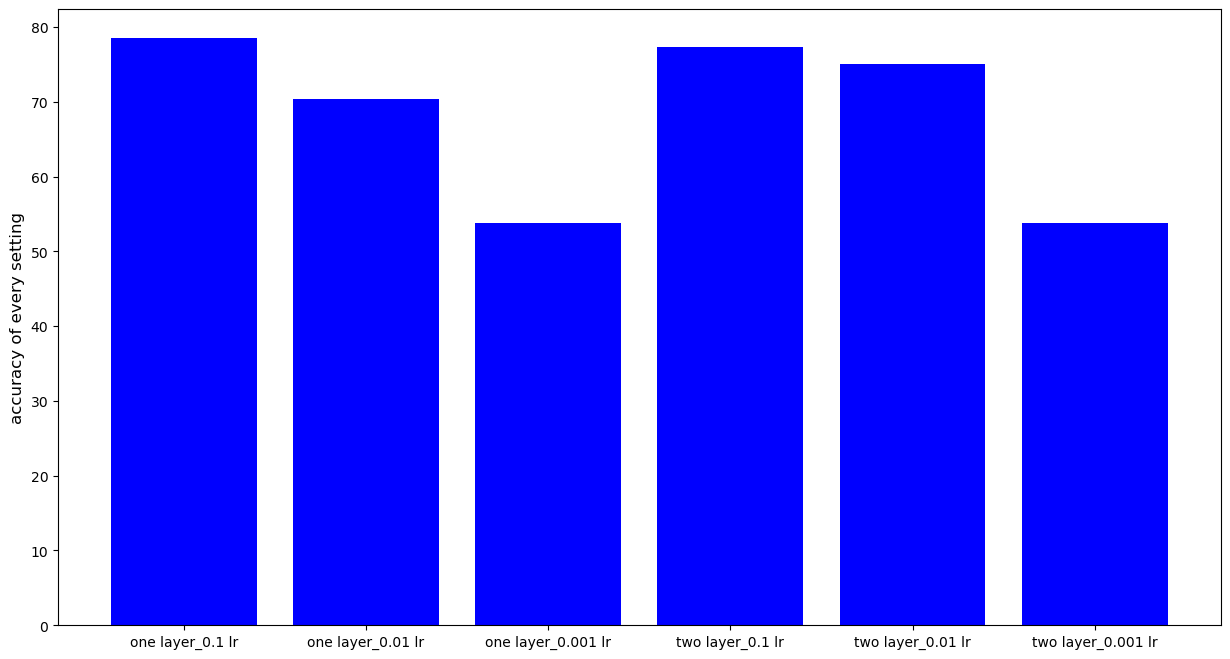

78/78 - 0s - loss: 0.5120 - acc: 0.7692
Restored model best performance, accuracy: 76.92%


In [14]:
plt.figure(figsize = (15,8))

whole_list = []

lang = ['one layer_0.1 lr', 'one layer_0.01 lr', 'one layer_0.001 lr', 'two layer_0.1 lr', 'two layer_0.01 lr', 'two layer_0.001 lr']

for elem in six_ann_scores:
    whole_list.append(np.mean(elem))   

plt.bar(range(len(whole_list)), whole_list, fc='b', tick_label=lang)

plt.ylabel("accuracy of every setting", fontsize="12")

plt.show()

x_train, x_test, y_train, y_test = train_test_split(all_df.iloc[:,1:], all_df['pCR (outcome)'], test_size=0.3, random_state=1, stratify=all_df['pCR (outcome)'])

model_two_layer_1.load_weights('./classification_models/fold_1_model_two_layer_1.hdf5')

y_pred=model_two_layer_1.predict(np.array(x_test))

loss, acc = model_two_layer_1.evaluate(np.array(x_test), np.array(y_test), verbose=2)
print("Restored model best performance, accuracy: {:5.2f}%".format(100 * acc))